<a href="https://colab.research.google.com/github/dede0702/mnist-digit-4-gan/blob/main/GAN_MNIST_Digito_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ```
🧩 Etapa 1: Instalar dependências
 ```

In [22]:
!pip install torch torchvision matplotlib

 ```
📦 Etapa 2: Importar bibliotecas
 ```

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets # Alterado para torchvision
import matplotlib.pyplot as plt



```
📁 Etapa 3: Carregar apenas os dígitos 4 do MNIST (usando torchvision)
```



In [24]:
class MNIST4Dataset(Dataset):
    def __init__(self):
        # Carregar o dataset MNIST usando torchvision
        mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

        # Filtrar para incluir apenas os dígitos '4'
        idx = mnist_trainset.targets == 4
        data_4_filtered = mnist_trainset.data[idx] # Tensor de formato (N, 28, 28), tipo uint8

        # Converter para float, normalizar para [-1, 1] e adicionar dimensão de canal
        # Imagens são (H, W), precisamos de (C, H, W) para Conv2d, então (1, 28, 28)
        data_normalized = data_4_filtered.float() / 255.0  # Escala para [0, 1]
        self.data = (data_normalized * 2.0) - 1.0      # Escala para [-1, 1]
        self.data = self.data.unsqueeze(1)   # Adiciona dimensão de canal: (N, 1, 28, 28)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

dataset = MNIST4Dataset()
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

Número de amostras do dígito 4: 5842


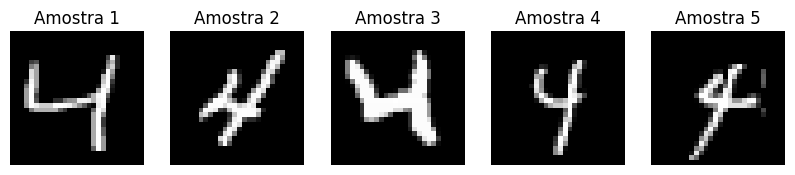

In [25]:
# Visualizar algumas imagens do dataset para confirmar
print(f"Número de amostras do dígito 4: {len(dataset)}")
fig, axs = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    img = dataset[i].squeeze().numpy() # Remove canal, converte para numpy
    axs[i].imshow(img, cmap='gray')
    axs[i].set_title(f"Amostra {i+1}")
    axs[i].axis('off')
plt.show()



```
🧠 Etapa 4: Definir o Discriminador
```



In [26]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False), # Imagens 1x28x28
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3), # Adicionado Dropout após primeira conv como no original (mas antes não tinha no código)
            # Ação: 64 x 14 x 14
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128), # Adicionado BatchNorm para estabilidade
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            # Ação: 128 x 7 x 7
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Observação: Adicionei bias=False nas camadas convolucionais e BatchNorm2d no Discriminador, que são práticas comuns em arquiteturas DCGAN e podem ajudar na estabilidade.
# O Dropout original foi mantido, embora sua posição possa variar.



```
🎨 Etapa 5: Definir o Gerador
```



In [27]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # Entrada: latent_dim
            nn.Linear(latent_dim, 256 * 7 * 7),
            # Não há LeakyReLU/BatchNorm1d na versão original diretamente após o Linear antes do Unflatten
            # Mas o código fornecido tinha. Vou mantê-lo.
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(256 * 7 * 7),
            nn.Unflatten(1, (256, 7, 7)),
            # Ação: 256 x 7 x 7
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False), # output 128 x 14 x 14
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # Ação: 128 x 14 x 14
            nn.ConvTranspose2d(128, 1, 4, 2, 1, bias=False),   # output 1 x 28 x 28
            nn.Tanh() # Normaliza a saída para [-1, 1]
        )

    def forward(self, z):
        return self.model(z)

#Observação: Adicionei bias=False nas camadas ConvTranspose2d do Gerador, uma prática comum em DCGANs quando se usa BatchNorm. A estrutura original do Gerador foi mantida.



```
⚙️ Etapa 6: Inicializar modelos, otimizadores e parâmetros
```



In [28]:
latent_dim = 100
# batch_size definido no DataLoader (64)
epochs = 100 # Pode precisar de ajuste; 100 é um bom começo
lr = 0.0002
beta1 = 0.5 # Beta1 recomendado para Adam em GANs
beta2 = 0.999

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

Usando dispositivo: cpu


In [29]:
# Inicialização de pesos (opcional, mas pode ajudar)
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

generator.apply(weights_init)
discriminator.apply(weights_init)

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))
loss_fn = nn.BCELoss() # Binary Cross Entropy Loss

real_label = 1.
fake_label = 0.



```
🔁 Etapa 7: Treinar a GAN e Visualizar Resultados Parciais
```



Epoch [1/100] | Loss_D: 0.3602 | Loss_G: 1.9476
Epoch [2/100] | Loss_D: 0.4738 | Loss_G: 1.8353
Epoch [3/100] | Loss_D: 0.7217 | Loss_G: 1.5790
Epoch [4/100] | Loss_D: 0.8733 | Loss_G: 0.7849
Epoch [5/100] | Loss_D: 0.9333 | Loss_G: 1.1432
Epoch [6/100] | Loss_D: 1.1028 | Loss_G: 0.9215
Epoch [7/100] | Loss_D: 0.8960 | Loss_G: 1.3306
Epoch [8/100] | Loss_D: 0.7344 | Loss_G: 1.7089
Epoch [9/100] | Loss_D: 0.9527 | Loss_G: 1.5294
Epoch [10/100] | Loss_D: 1.2110 | Loss_G: 2.3745


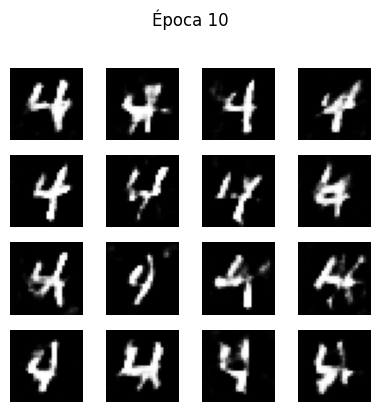

Epoch [11/100] | Loss_D: 0.7189 | Loss_G: 1.3478
Epoch [12/100] | Loss_D: 0.9132 | Loss_G: 1.7935
Epoch [13/100] | Loss_D: 1.0521 | Loss_G: 2.7719
Epoch [14/100] | Loss_D: 0.7205 | Loss_G: 2.5730
Epoch [15/100] | Loss_D: 1.1173 | Loss_G: 3.4149
Epoch [16/100] | Loss_D: 0.8403 | Loss_G: 1.5680
Epoch [17/100] | Loss_D: 0.6617 | Loss_G: 1.7721
Epoch [18/100] | Loss_D: 0.7500 | Loss_G: 1.6191
Epoch [19/100] | Loss_D: 1.1815 | Loss_G: 0.7307
Epoch [20/100] | Loss_D: 0.9128 | Loss_G: 2.5327


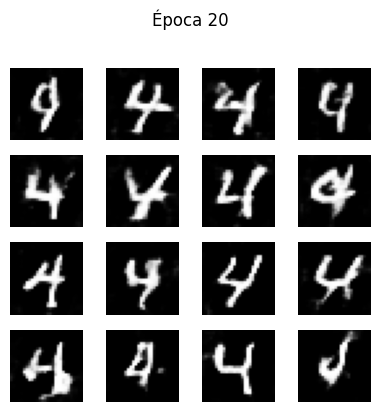

Epoch [21/100] | Loss_D: 1.0371 | Loss_G: 1.4595
Epoch [22/100] | Loss_D: 0.6755 | Loss_G: 1.9455
Epoch [23/100] | Loss_D: 0.8850 | Loss_G: 1.2978
Epoch [24/100] | Loss_D: 0.8093 | Loss_G: 1.8771
Epoch [25/100] | Loss_D: 0.8340 | Loss_G: 1.1002
Epoch [26/100] | Loss_D: 1.0174 | Loss_G: 2.1097
Epoch [27/100] | Loss_D: 1.2203 | Loss_G: 2.4185
Epoch [28/100] | Loss_D: 1.1863 | Loss_G: 0.6314
Epoch [29/100] | Loss_D: 0.6408 | Loss_G: 1.4583
Epoch [30/100] | Loss_D: 1.2200 | Loss_G: 2.0936


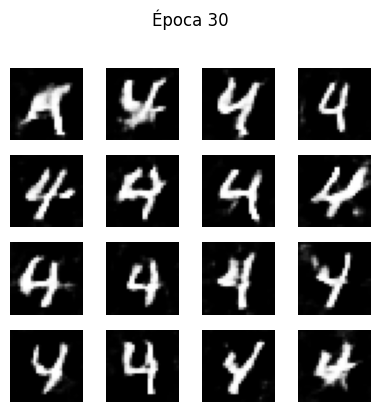

Epoch [31/100] | Loss_D: 1.0647 | Loss_G: 0.9791
Epoch [32/100] | Loss_D: 1.0637 | Loss_G: 1.3889
Epoch [33/100] | Loss_D: 1.4113 | Loss_G: 0.3431
Epoch [34/100] | Loss_D: 1.1983 | Loss_G: 1.4048
Epoch [35/100] | Loss_D: 1.0498 | Loss_G: 1.1890
Epoch [36/100] | Loss_D: 0.8064 | Loss_G: 1.2907
Epoch [37/100] | Loss_D: 0.9210 | Loss_G: 1.0731
Epoch [38/100] | Loss_D: 1.1307 | Loss_G: 1.9424
Epoch [39/100] | Loss_D: 1.1502 | Loss_G: 1.1179
Epoch [40/100] | Loss_D: 1.0409 | Loss_G: 1.0617


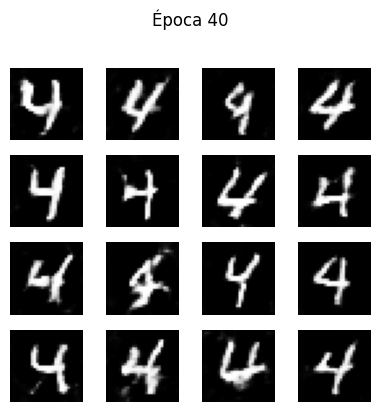

Epoch [41/100] | Loss_D: 0.9918 | Loss_G: 0.9396
Epoch [42/100] | Loss_D: 0.8928 | Loss_G: 1.4102
Epoch [43/100] | Loss_D: 1.0210 | Loss_G: 1.4230
Epoch [44/100] | Loss_D: 0.7982 | Loss_G: 1.8544
Epoch [45/100] | Loss_D: 0.8682 | Loss_G: 0.7276
Epoch [46/100] | Loss_D: 1.0566 | Loss_G: 0.8094
Epoch [47/100] | Loss_D: 0.8981 | Loss_G: 2.1263
Epoch [48/100] | Loss_D: 0.7987 | Loss_G: 1.9185
Epoch [49/100] | Loss_D: 1.1466 | Loss_G: 1.5993
Epoch [50/100] | Loss_D: 1.1191 | Loss_G: 1.6836


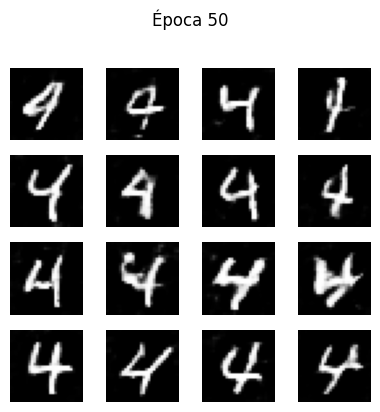

Epoch [51/100] | Loss_D: 1.3785 | Loss_G: 0.7850
Epoch [52/100] | Loss_D: 0.9391 | Loss_G: 0.8195
Epoch [53/100] | Loss_D: 0.6603 | Loss_G: 3.1523
Epoch [54/100] | Loss_D: 0.8413 | Loss_G: 1.3415
Epoch [55/100] | Loss_D: 0.7863 | Loss_G: 1.1873
Epoch [56/100] | Loss_D: 0.9572 | Loss_G: 0.4935
Epoch [57/100] | Loss_D: 0.7167 | Loss_G: 1.9253
Epoch [58/100] | Loss_D: 1.1333 | Loss_G: 1.8563
Epoch [59/100] | Loss_D: 1.0480 | Loss_G: 0.8497
Epoch [60/100] | Loss_D: 0.7751 | Loss_G: 1.6130


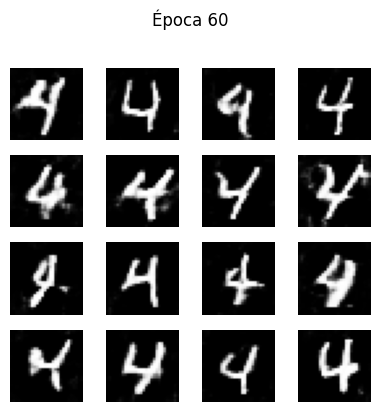

Epoch [61/100] | Loss_D: 1.4086 | Loss_G: 0.2318
Epoch [62/100] | Loss_D: 0.9441 | Loss_G: 2.1879
Epoch [63/100] | Loss_D: 0.8397 | Loss_G: 1.1409
Epoch [64/100] | Loss_D: 0.8097 | Loss_G: 1.3620
Epoch [65/100] | Loss_D: 0.8357 | Loss_G: 2.9326
Epoch [66/100] | Loss_D: 1.2866 | Loss_G: 0.3515
Epoch [67/100] | Loss_D: 1.3113 | Loss_G: 0.4023
Epoch [68/100] | Loss_D: 0.9646 | Loss_G: 1.1904
Epoch [69/100] | Loss_D: 1.0956 | Loss_G: 1.1793
Epoch [70/100] | Loss_D: 1.3105 | Loss_G: 1.6623


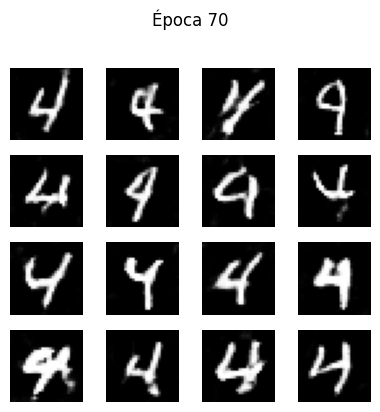

Epoch [71/100] | Loss_D: 1.0364 | Loss_G: 2.4099
Epoch [72/100] | Loss_D: 0.8759 | Loss_G: 1.4882
Epoch [73/100] | Loss_D: 0.9127 | Loss_G: 2.4643
Epoch [74/100] | Loss_D: 0.8270 | Loss_G: 1.2299
Epoch [75/100] | Loss_D: 0.8992 | Loss_G: 0.8654
Epoch [76/100] | Loss_D: 1.3212 | Loss_G: 1.8718
Epoch [77/100] | Loss_D: 0.8580 | Loss_G: 1.1025
Epoch [78/100] | Loss_D: 1.3014 | Loss_G: 1.8720
Epoch [79/100] | Loss_D: 0.8706 | Loss_G: 1.4671
Epoch [80/100] | Loss_D: 1.0600 | Loss_G: 1.8566


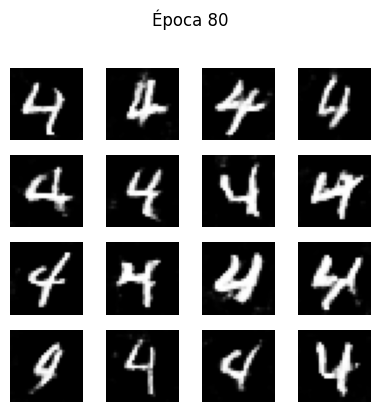

Epoch [81/100] | Loss_D: 1.9861 | Loss_G: 1.3242
Epoch [82/100] | Loss_D: 1.2427 | Loss_G: 1.4172
Epoch [83/100] | Loss_D: 1.4958 | Loss_G: 1.7755
Epoch [84/100] | Loss_D: 1.2502 | Loss_G: 0.9831
Epoch [85/100] | Loss_D: 1.2050 | Loss_G: 0.9738
Epoch [86/100] | Loss_D: 0.8052 | Loss_G: 2.0571
Epoch [87/100] | Loss_D: 1.0542 | Loss_G: 1.0279
Epoch [88/100] | Loss_D: 1.5796 | Loss_G: 0.4229
Epoch [89/100] | Loss_D: 1.0454 | Loss_G: 0.8371
Epoch [90/100] | Loss_D: 0.9396 | Loss_G: 1.4732


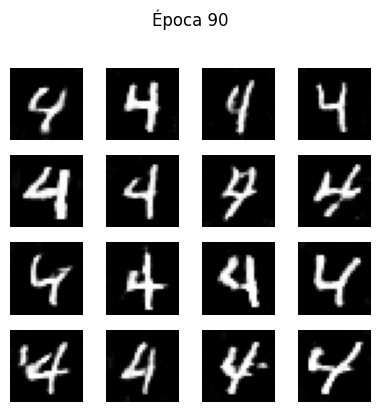

Epoch [91/100] | Loss_D: 1.1221 | Loss_G: 2.4697
Epoch [92/100] | Loss_D: 0.9923 | Loss_G: 1.4577
Epoch [93/100] | Loss_D: 0.9117 | Loss_G: 1.2234
Epoch [94/100] | Loss_D: 1.3801 | Loss_G: 0.8027
Epoch [95/100] | Loss_D: 0.7946 | Loss_G: 1.2320
Epoch [96/100] | Loss_D: 0.8536 | Loss_G: 1.0165
Epoch [97/100] | Loss_D: 1.4321 | Loss_G: 0.5998
Epoch [98/100] | Loss_D: 1.1267 | Loss_G: 1.0881
Epoch [99/100] | Loss_D: 1.1275 | Loss_G: 0.9437
Epoch [100/100] | Loss_D: 1.2442 | Loss_G: 2.3770


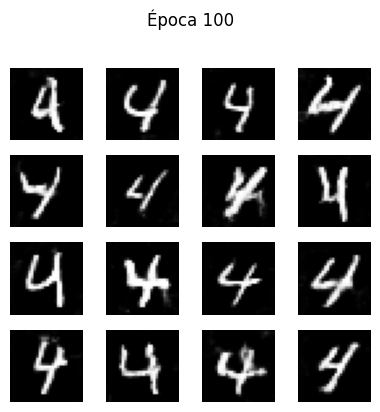

In [30]:
for epoch in range(epochs):
    for i, real_imgs in enumerate(dataloader):
        real_imgs = real_imgs.to(device)
        b_size = real_imgs.size(0)

        # --- Treinar o Discriminador ---
        optimizer_D.zero_grad()

        # Labels para imagens reais e falsas
        labels_real = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        labels_fake = torch.full((b_size,), fake_label, dtype=torch.float, device=device)

        # Perda com imagens reais
        output_real = discriminator(real_imgs).view(-1)
        loss_real = loss_fn(output_real, labels_real)

        # Gerar imagens falsas
        noise = torch.randn(b_size, latent_dim, device=device)
        fake_imgs = generator(noise)

        # Perda com imagens falsas
        # Usar .detach() para não calcular gradientes para o gerador aqui
        output_fake = discriminator(fake_imgs.detach()).view(-1)
        loss_fake = loss_fn(output_fake, labels_fake)

        # Perda total do discriminador e otimização
        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # --- Treinar o Gerador ---
        optimizer_G.zero_grad()

        # O gerador quer que o discriminador pense que as imagens falsas são reais
        labels_gen = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output_gen = discriminator(fake_imgs).view(-1) # Não usar .detach() aqui
        loss_G = loss_fn(output_gen, labels_gen)

        # Perda total do gerador e otimização
        loss_G.backward()
        optimizer_G.step()

    # Imprimir perdas ao final de cada época
    print(f"Epoch [{epoch+1}/{epochs}] | Loss_D: {loss_D.item():.4f} | Loss_G: {loss_G.item():.4f}")

    # Gerar e visualizar imagens (a cada 10 épocas)
    if (epoch + 1) % 10 == 0:
        with torch.no_grad(): # Não calcular gradientes durante a geração de amostras
            # Usar um tensor de ruído fixo para ver a evolução das mesmas amostras (opcional)
            # test_noise = getattr(generator, 'fixed_noise', torch.randn(16, latent_dim, device=device))
            # generator.fixed_noise = test_noise
            test_noise = torch.randn(16, latent_dim, device=device) # Ou gerar novo ruído sempre

            generated_imgs = generator(test_noise).cpu() # Mover para CPU para matplotlib

        # Ajustar visualização para o formato da imagem de saída do gerador (1, 28, 28)
        # As imagens estão em [-1, 1], reescale para [0, 1] para visualização se necessário ou imshow lida bem.
        # generated_imgs = (generated_imgs + 1) / 2 # Opcional: reescalar para [0,1]

        fig, axs = plt.subplots(4, 4, figsize=(4, 4))
        plt.suptitle(f"Época {epoch+1}", y=1.02) # Adicionar título com a época
        for k_ax, img_tensor in enumerate(generated_imgs):
            row, col = k_ax // 4, k_ax % 4
            ax = axs[row, col]
            ax.imshow(img_tensor.squeeze().numpy(), cmap='gray') # .squeeze() remove a dimensão do canal
            ax.axis('off')
        plt.tight_layout()
        plt.show()



```
💾 Etapa 8: Salvar os modelos (após o treinamento)
```



In [31]:
# Salvar os pesos dos modelos (state_dict)
torch.save(generator.state_dict(), "generator_digit4.pt")
torch.save(discriminator.state_dict(), "discriminator_digit4.pt")

print("Modelos salvos!")

# Para carregar os modelos posteriormente:
# generator = Generator(latent_dim)
# generator.load_state_dict(torch.load("generator_digit4.pt"))
# discriminator = Discriminator()
# discriminator.load_state_dict(torch.load("discriminator_digit4.pt"))
# generator.to(device)
# discriminator.to(device)
# generator.eval() # Para inferência
# discriminator.eval() # Para inferência

Modelos salvos!
